# **Audio Denoiser**

## 0 > Introduction
### We are going to train a neural network that denoises audio.
Use an editor that supports Jupyter notebook. 

At first I didn't like the idea of using Jupyter, but after trying it I liked it so I suggest you to try it!

(Jupyter extention on VSCode works well but sometimes it gets buggy and you need to restart it which can easily be done by a 🟥️Stop button)


In [33]:
for c in [:black, :red, :green, :yellow, :blue, :magenta, :cyan, :white,
	:light_black, :light_red, :light_green, :light_yellow,
	:light_blue, :light_magenta, :light_cyan, :light_white,
]
	printstyled("Test color: $c\n"; color = c)
end


Test color: black
Test color: red
Test color: green
Test color: yellow
Test color: blue
Test color: magenta
Test color: cyan
Test color: white
Test color: light_black
Test color: light_red
Test color: light_green
Test color: light_yellow
Test color: light_blue
Test color: light_magenta
Test color: light_cyan
Test color: light_white


## 1 > Dependencies


### 1.1 > Ensure that your environment has the dependencies:

In [34]:
using Pkg

# Returns a list of all of the installed packages.
function getAvlblPkgs()
	return [dep.name for (uuid, dep) in Pkg.dependencies() if dep.is_direct_dep]
end


# Checks the needed packages one by one and installs if not already installed.
function ensure_packages(needed_packages::String...)
	printstyled("Handling the dependencies...\n"; color = :magenta)
	# all of the available packages
	allpkgs = getAvlblPkgs()
	for pkg in needed_packages
		if pkg in allpkgs
			printstyled(pkg; bold = true)
			printstyled(" is already installed.\n"; color = :blue)
		else
			printstyled("Installing "; color = :green)
			printstyled(pkg; bold = true)
			printstyled("...\n"; color = :green)
			Pkg.add(pkg)
		end
	end
end

ensure_packages(
	"WAV",
	"Plots",
	"Random",
	"LinearAlgebra",
	"SignalAnalysis",
)


Handling the dependencies...
WAV is already installed.
Plots is already installed.
Random is already installed.
LinearAlgebra is already installed.
SignalAnalysis is already installed.


### 1.2 > Include the dependencies:

In [35]:
using WAV
using Plots
using Random
using LinearAlgebra
using SignalAnalysis

## 2 > General Preprocessing
### 2.1 > Read Audio Files
We develope a function to read and prepare .wav file that normalizes it into a vector and its frequency. 

Normalization here seemed good but not essential.


In [36]:
function preprocess_audio(file_path::String, sr = 48000)
	aud, fs = wavread(file_path)

	y = length(aud[1, :])
	x = length(aud) ÷ y

	# Choosing the first array of the stereo matrix
	aud = aud[:, 1]

	# Matching the data rate
	if fs != sr
		ratio = sr / fs
		aud = resample(aud, ratio)
	end

	# Normalization: range (-1,1)
	aud = aud / maximum(abs.(aud))
	# aud_min, aud_max = extrema(aud)
	# if aud_max > aud_min
	# 	aud = @. (aud - aud_min) / (aud_max - aud_min) * 2 - 1
	# end
	# Ensure the audio is in the range [-1, 1]

	return aud, sr
end

# Examples for loading audio file:
ex_noisy_wav, fs = preprocess_audio("./aud/learn/noisy/noisy_audio.wav")
ex_clean_wav, fs = preprocess_audio("./aud/learn/clean/clean_audio.wav")

# ex_noisy_wav, fs = preprocess_audio("./aud/input/audio_to_denoise.wav")
# ex_clean_wav, fs = preprocess_audio("./aud/input/audio_to_denoise.wav")



([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  -0.00022820629849383843, -0.00022820629849383843, -0.00022820629849383843, -0.00022820629849383843, -0.00022820629849383843, -0.00022820629849383843, -0.00022820629849383843, -0.00022820629849383843, -0.00022820629849383843, -0.00022820629849383843], 48000)

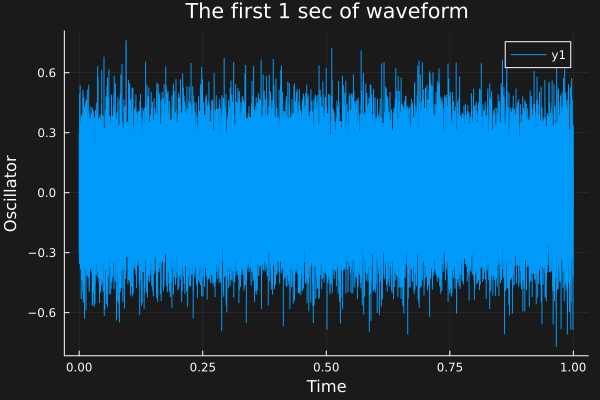

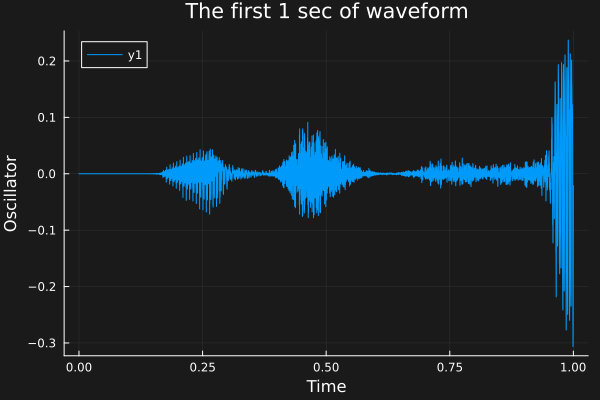

In [37]:
# wav: in form of vector{Float64}
# howmanysec: The first n seconds you want to plot
function plotWave(wav; howmanysec = 1)
	maxshow = Int(floor(howmanysec * fs))
	x = (0:(min(maxshow, length(wav))-1)) * (1/fs)
	y = wav[1:min(maxshow, length(wav))]
	plot(x, y, xlabel = "Time", ylabel = "Oscillator", title = "The first $howmanysec sec of waveform", background = "gray10")
end

display(plotWave(ex_noisy_wav, howmanysec = 1))
display(plotWave(ex_clean_wav, howmanysec = 1))


## 3 > Implementations


### 3.1 > The First Major Version
In the first version we have done this using a simple Adaline network.


#### 3.1.1 > Audio Denoiser v1.0
In this edition, denoised audio is the direct output of Adaline network.


Loading files...
Training started...
Denoising audio...
Denoised audio saved to ./aud/output/denoised_audio_v1.0.wav
An image of training loss saved to ./log/loss_plot_v1.0.png


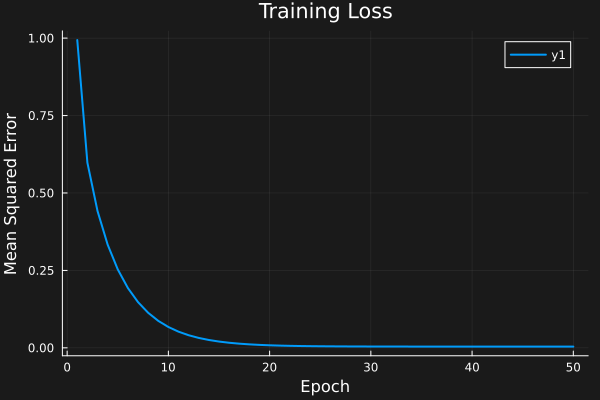

Adaline(-0.0005637270530643278, [0.0441560028281805, 0.04444794661389264, 0.046661648961196296, 0.05080730261471855, 0.050268534367034406, 0.05484740769026978, 0.05687270737324675, 0.061363699362124394, 0.062413008739371195, 0.06720397506876953  …  0.06704047938695856, 0.06137530487823178, 0.061832280152767136, 0.05627280195400374, 0.05200180163339519, 0.049822292274333796, 0.04890474489421501, 0.04465001115696207, 0.04473543710144124, 0.039537602892279027], 1.0e-5, 50, [0.9937416992254798, 0.5978037506043556, 0.4417914207446586, 0.3333255117357108, 0.2532412960584038, 0.19308564286194563, 0.14764158028077595, 0.11322270639066012, 0.08711237060177786, 0.06728134468301267  …  0.004014123437287646, 0.004010689774011972, 0.004008068331555291, 0.00400606697347274, 0.00400453901783908, 0.004003372482871523, 0.0040024818772916365, 0.004001801933198832, 0.004001282821767398, 0.004000886500886829])

In [38]:
mutable struct Adaline
	bias::Float64
	weights::Vector{Float64}
	learning_rate::Float64
	epochs::Int
	loss_history::Vector{Float64}

	function Adaline(input_size::Union{Int, Tuple}; learning_rate = 0.001, epochs = 100)
		bias = randn()
		weights = randn(input_size)
		new(bias, weights, learning_rate, epochs)
	end
end

function activation(adaline::Adaline, x::Float64)
	return x
end

function predict(adaline::Adaline, x::Vector{Float64})
	return activation(adaline, dot(x, adaline.weights) + adaline.bias)
end

function pad(vector::Vector, pad_size::Int)
	N = length(vector)
	padded_vector = Vector{Float64}(undef, N + 2 * pad_size)
	padded_vector[(pad_size+1):(pad_size+N)] = vector

	# Reflect audio to fill sides of the pad with real audio data
	for i in 1:pad_size
		# Reflect audio on the left side of the pad
		padded_vector[pad_size+1-i] = vector[i+1]
		# Reflect audio on the write side of the pad
		padded_vector[pad_size+N+i] = vector[N-i]
	end

	return padded_vector
end

function train!(adaline::Adaline, X::Matrix{Float64}, y::Vector{Float64})
	loss_history = Float64[]

	n_samples = size(X, 1)
	for _ in 1:adaline.epochs
		total_loss = 0.0
		for i in 1:n_samples
			xi = X[i, :]
			target = y[i]
			prediction = predict(adaline, xi)
			error = target - prediction
			total_loss += error^2
			adaline.weights .+= adaline.learning_rate * error * xi * 2
			adaline.bias += adaline.learning_rate * error * 2
		end

		push!(loss_history, total_loss / n_samples)
	end
	adaline.loss_history = loss_history
	return loss_history
end

function denoise_frame(adaline::Adaline, noisy_frame::Vector{Float64}, context_size::Int)
	# Simplified - use entire window
	predict(adaline, noisy_frame)
end

function create_training_data(noisy_wav::Vector{Float64}, clean_wav::Vector{Float64}, window_size::Int)
	@assert length(clean_wav) == length(noisy_wav)

	# Proper symmetric padding
	pad_size = window_size .÷ 2
	padded_noisy = pad(noisy_wav, pad_size)

	# Create training matrix 
	n_samples = length(clean_wav)
	X = zeros(Float64, n_samples, window_size)
	for i in 1:n_samples
		X[i, :] = padded_noisy[i:(i+window_size-1)]
	end

	return X, clean_wav
end

function train_an_adaline_for_denoising(noisy_audio::String, clean_audio::String; window_size::Int = 5, learning_rate = 0.00001, epochs = 50)
	if (window_size%2==0)
		window_size+=1
	end
	clean_wav, sr = preprocess_audio(clean_audio)
	noisy_wav, _ = preprocess_audio(noisy_audio)
	X, y = create_training_data(noisy_wav, clean_wav, window_size)
	adaline = Adaline(window_size; learning_rate = learning_rate, epochs = epochs)
	loss_history = train!(adaline, X, y)
	return adaline, loss_history
end

function denoise_audio(noisy_audio::String, adaline::Adaline, output_audio::String; context_size = 2)
	noisy_audio, fs = preprocess_audio(noisy_audio)
	window_size = length(adaline.weights)
	pad_size = window_size ÷ 2

	padded_noisy = pad(noisy_audio, pad_size)

	N = length(noisy_audio)
	X = zeros(Float64, N, window_size)
	for i in 1:N
		X[i, :] = padded_noisy[i:(i+window_size-1)]
	end

	denoised = zeros(N)
	for i in 1:N
		window = X[i, :]
		denoised[i] = denoise_frame(adaline, window, context_size)
	end
	# Normalize denoised audio
	denoised = denoised / maximum(abs.(denoised))
	wavwrite(denoised, output_audio; Fs = fs)
	return denoised, fs
end

function denoise_audio(window_size::Int = 25;ver::String="")
	printstyled("Loading files...\n"; color = :yellow)
	noisy_audio = "./aud/learn/noisy/noisy_audio.wav" #> to train
	clean_audio = "./aud/learn/clean/clean_audio.wav" #> to train
	
	input_audio = "./aud/input/noisy_test.wav" #> to denoise
	output_audio = "./aud/output/denoised_audio_v$ver.wav" #> to save

	# * input_audio = "./aud/learn/noisy/noisy_audio.wav"
	# * output_audio = "./aud/output/denoised_audio.wav"

	# Verify files exist
	for f in [clean_audio, noisy_audio, input_audio]
		isfile(f) || error("File not found: $f")
	end

	# Define and train an adaline for denoising
	printstyled("Training started...\n"; color = :magenta)
	adaline, loss_history = train_an_adaline_for_denoising(noisy_audio, clean_audio; window_size)

	# Denoising through the trained adaline
	printstyled("Denoising audio...\n"; color = :magenta)
	denoise_audio(input_audio, adaline, output_audio)
	printstyled("Denoised audio saved to $output_audio\n"; color = :light_green)

	# Optional: Plot training loss
	display(plot(loss_history, title = "Training Loss", xlabel = "Epoch", ylabel = "Mean Squared Error", lw = 2, background = "gray10"))
	lossimglog = "./log/loss_plot_v$ver.png"
	savefig(lossimglog)
	printstyled("An image of training loss saved to $lossimglog\n"; color = :green)
	display(adaline)
end

denoise_audio(;ver="1.0")



#### 3.1.2 > Audio Denoiser v1.1
In this edition, Adaline outputs the amount of error it predicts, and then we subtract it from the noisy input sound. 

To do this, we have edited two functions (create_training_data and denoise_audio) 

> Changed parts are marked with comments. 

Then we run denoise_audio() again 


Loading files...
Training started...
Denoising audio...
Denoised audio saved to ./aud/output/denoised_audio_v1.1.wav
An image of training loss saved to ./log/loss_plot_v1.1.png


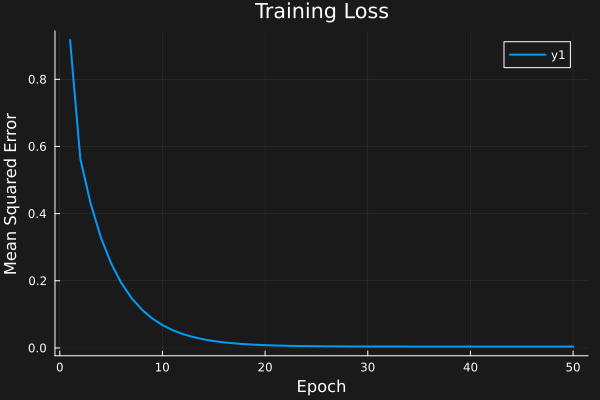

Adaline(0.0005636540740584126, [-0.04307667629370136, -0.04560298033215866, -0.04796586936424156, -0.04873635329848558, -0.050996290437000026, -0.053795540763588105, -0.05574878432099196, -0.06038565766932795, -0.061482571242786214, -0.06867315322813769  …  -0.06383829647918517, -0.06350372644160163, -0.06022841994603309, -0.056763273139712994, -0.052860239402767094, -0.05083902189566637, -0.047855648188121866, -0.046680667119610934, -0.04088208805795328, -0.04055628337359442], 1.0e-5, 50, [0.9167597282750365, 0.5631929191794955, 0.43029117648684195, 0.3290440702415803, 0.2518580858170658, 0.1930107492814778, 0.1481420493411671, 0.1139294816317592, 0.0878408609981806, 0.06794613368757867  …  0.0040142240674533565, 0.004010763506632815, 0.004008122247442787, 0.004006106300167323, 0.004004567614027644, 0.004003393196151152, 0.0040024968084013705, 0.004001812631182548, 0.004001290428141876, 0.004000891856150169])

In [39]:
function create_training_data(noisy_wav::Vector{Float64}, clean_wav::Vector{Float64}, window_size::Int)
	@assert length(clean_wav) == length(noisy_wav)

	# Proper symmetric padding
	pad_size = window_size .÷ 2
	padded_noisy = pad(noisy_wav, pad_size)

	# Create training matrix
	n_samples = length(clean_wav)
	X = zeros(Float64, n_samples, window_size)
	for i in 1:n_samples
		X[i, :] = padded_noisy[i:(i+window_size-1)]
	end

	# ! return X, clean_wav
	y = noisy_wav - clean_wav # * New line *
	return X, y # * New line *
end

function denoise_audio(noisy_audio::String, adaline::Adaline, output_audio::String; context_size = 2)
	noisy_audio, fs = preprocess_audio(noisy_audio)
	window_size = length(adaline.weights)
	pad_size = window_size ÷ 2

	padded_noisy = pad(noisy_audio, pad_size)

	N = length(noisy_audio)
	X = zeros(Float64, N, window_size)
	for i in 1:N
		X[i, :] = padded_noisy[i:(i+window_size-1)]
	end

	error = zeros(N) # * New line *
	denoised = zeros(N)
	for i in 1:N
		window = X[i, :]
		# ! denoised[i] = denoise_frame(adaline, window, context_size)
		error[i] = denoise_frame(adaline, window, context_size) # * New line *
		denoised[i] = noisy_audio[i] - error[i] # * New line *
	end
	# Normalize denoised audio
	denoised = denoised / maximum(abs.(denoised))
	wavwrite(denoised, output_audio; Fs = fs)
	return denoised, fs
end

denoise_audio(;ver="1.1")


##### v1.1 Results: The results for this editation were not much better


#### 3.1.2 > Audio Denoiser v1.2
In this edition, we use Backpropagation


### 3.2 > The Second Major Version
In this version we are gonna... !!!


#### 3.2.1 > STFTModel
We use a structure to hold transformation properties, so we call it STFTModel.

In [41]:
# Holds the features of a Short Term Fourier Transforamtion
mutable struct STFTModel
	mag::Union{Matrix{Float64}, Matrix{ComplexF64}} #Magnitudes
	time::Union{Nothing, AbstractRange{Float64}, Vector{Float64}}
	freq::Union{Nothing, AbstractRange{Float64}, Vector{Float64}}
	n::Union{Int, Nothing}
	noverlap::Union{Int, Nothing}
	nfft::Union{Int, Nothing}
	fs::Union{Int, Float64}
	window::Union{AbstractVector, Function, Nothing}

	function STFTModel(
		mag::Union{Matrix{Float64}, Matrix{ComplexF64}},
		time::Union{Nothing, AbstractRange{Float64}, Vector{Float64}} = nothing,
		freq::Union{Nothing, AbstractRange{Float64}, Vector{Float64}} = nothing;
		n::Union{Int, Nothing} = nothing,
		noverlap::Union{Int, Nothing} = nothing,
		nfft::Union{Int, Nothing} = nothing,
		fs::Union{Int, Float64} = 48000.0,
		window::Union{AbstractVector, Function, Nothing} = nothing,
	)
		new(mag, time, freq, n, noverlap, nfft, fs, window)
	end
end

function height(model::STFTModel)
	return model.freq === nothing ? size(model.mag, 1) : length(model.freq)
end

function width(model::STFTModel)
	return model.time === nothing ? size(model.mag, 2) : length(model.time)
end

S = stft(ex_clean_wav; fs = 48000)
STFTModel(S)


STFTModel(ComplexF64[0.15107256960292106 + 0.0im -0.7512551346417164 + 0.0im … 1.7654039251483353 + 0.0im -0.12619808306709268 + 0.0im; 0.17453313876863974 - 0.02140690708372889im -0.6621900291915364 - 0.007600649178935652im … 1.937560403151002 + 0.14882274914028157im 0.006669171522015904 - 0.027767712446290574im; … ; 0.0031754663163334473 + 0.0022178137132239373im -0.0074751520826654705 - 0.00028310542362338514im … -0.019247669049972382 - 0.0009623934966282582im 0.0010815975984829018 - 0.003789362971257669im; -0.009584664536741366 + 0.0im -0.009128251939753529 + 0.0im … -0.030579643998175254 + 0.0im -0.002966681880419854 + 0.0im], nothing, nothing, nothing, nothing, nothing, 48000.0, nothing)

#### 3.2.2 > Function to convert wav into STFT (Short Term Fourier Transform).

##### ```Tips!```

+ The human ear can distinguish between sounds with a range of frequencies from approximately 20 Hz to 20,000 Hz. 

+ ```Tip to set n:```
 The smallest frequency change that normal-hearing adults can detect is of the order of 0.2–0.3% for frequencies between 250–4000 Hz. This means for a 1000 Hz tone, a change of 2-3 Hz might be noticeable, but a 1 Hz change would likely go undetected. [reference](https://www.sciencedirect.com/topics/immunology-and-microbiology/frequency-discrimination) 

+ ```Tip to set noverlap:```
The number of distinct beats (or repetitions) per second that a person can perceive is around 10. This means that above a certain beat frequency, the brain switches from hearing distinct beats to perceiving a continuous sound, like a buzz or tone. 

In [42]:
using SignalAnalysis

function toSTFT(wav, n = 16000, noverlap = 12000; nfft = nextfastfft(n), fs = 48000, window = hamming(n))
	# Compute STFT
	# n: Window size (65536 samples)
	# noverlap: Overlap (65280 samples, i.e., 256 samples hop size)
	mags = stft(wav, n, noverlap; nfft, fs, window)
	# Potential Alternatives:
	# S = stft(wav, n, noverlap; fs, window)
	# S = stft(wav, n = div(length(s), 8), noverlap = div(n, 2); onesided = eltype(s)<:Real, nfft = nextfastfft(n), fs = 1, window = nothing)
	# S = stft(aud, n, noverlap; onesided = eltype(aud)<:Real, nfft = nextfastfft(n), fs = fs)

	# Create time and frequency axes
	n_freq = size(mags, 1)
	n_time = size(mags, 2)
	freq = (0:(n_freq-1)) * (fs / n)  # Frequencies: 0 to fs/2
	time = (0:(n_time-1)) * (n - noverlap) / fs  # Time points in seconds

	println("The size of this STFT model is: ", size(mags))
	println("Time range of this model: ", time)
	println("Frequency range of this model: ", freq)
	println()
	return STFTModel(mags, time, freq; n, noverlap, nfft, fs, window)
end

# Example for calculating STFT:
ex_noisy_stft = toSTFT(ex_noisy_wav)
ex_clean_stft = toSTFT(ex_clean_wav)


The size of this STFT model is: (8001, 45)
Time range of this model: 0.0:0.08333333333333333:3.6666666666666665
Frequency range of this model: 0.0:3.0:24000.0

The size of this STFT model is: (8001, 45)
Time range of this model: 0.0:0.08333333333333333:3.6666666666666665
Frequency range of this model: 0.0:3.0:24000.0



STFTModel(ComplexF64[0.013849366740341484 + 0.0im -0.005888522185735018 + 0.0im … -0.03556011627808406 + 0.0im -0.07122587184214627 + 0.0im; 0.01138965644809755 + 0.003993817981480434im -0.0077884791126056705 - 0.008659310513731927im … -0.004846440561834604 - 0.009008545697231751im 0.057239592907745065 - 0.027658385409952024im; … ; 0.0012458668526517678 + 0.002126791544402745im 0.00431767416847916 + 0.00018053252123967876im … 0.0025608290165761837 + 0.00010237157824584484im -0.00027790288655312953 - 0.00358254599262702im; -0.0032658689372398603 + 0.0im -0.005095979121949597 + 0.0im … -0.003192556972804208 + 0.0im -0.00023951371836978402 + 0.0im], 0.0:0.08333333333333333:3.6666666666666665, 0.0:3.0:24000.0, 16000, 12000, 16000, 48000, [0.08000000000000002, 0.08000003547332438, 0.08000014189329208, 0.08000031925988668, 0.0800005675730808, 0.08000088683283617, 0.0800012770391035, 0.08000173819182269, 0.08000227029092255, 0.080002873336321  …  0.080002873336321, 0.08000227029092255, 0.0800

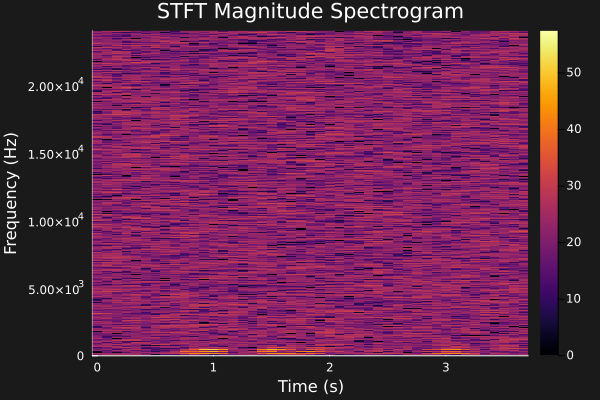

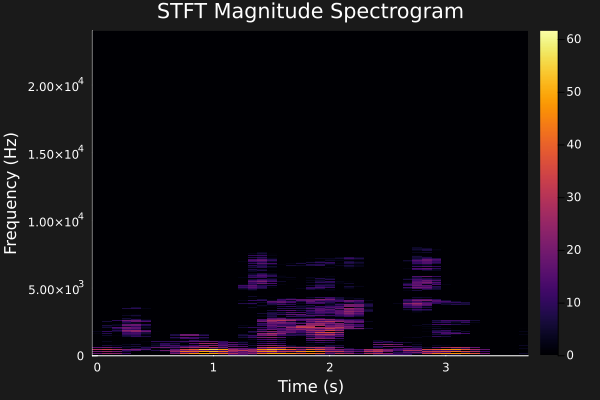

In [43]:
function heatmapSTFT(stftmodel::STFTModel; in_db::Bool = false)
	# Prepare magnitude spectrogram
	mag = abs.(stftmodel.mag)

	# Convert to decibel if it is requested
	if in_db
		mag = amp2db.(mag .+ floatmin()) # Add small constant to avoid log(0)
	end

	return heatmap(stftmodel.time, stftmodel.freq, mag,
		title = "STFT Magnitude Spectrogram",
		xlabel = "Time (s)",
		ylabel = "Frequency (Hz)",
		clim = (0, maximum(mag)),  # Adjust color limits
		background = "gray10",
	)
end

in_db = true # We convert them to decibel scale to help small waves and noises appear in the heatmap
display(heatmapSTFT(ex_noisy_stft; in_db))
display(heatmapSTFT(ex_clean_stft; in_db))
# Alternative but HEAVY:
# heatmapSTFT(toSTFT(ex_noisy_wav,512,0; fs); in_db = true)
# heatmapSTFT(toSTFT(ex_clean_wav,512,0; fs); in_db = true)


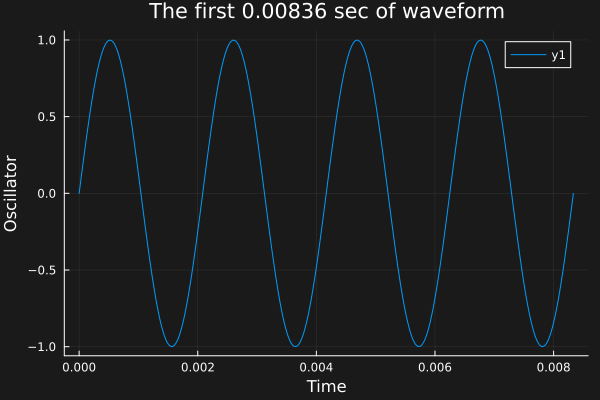

The size of this STFT model is: (8001, 116)
Time range of this model: 0.0:0.08333333333333333:9.583333333333332
Frequency range of this model: 0.0:3.0:24000.0



STFTModel(ComplexF64[-0.5270182555902564 + 0.0im -0.526208358693667 + 0.0im … -0.5277721514932427 + 0.0im -0.5270569515863273 + 0.0im; 0.22505891646131015 - 0.00021366005188120686im 0.2237794802656919 + 0.0012869554713594413im … 0.22562714377094478 + 0.0005068266366221632im 0.22386279075091137 + 0.00047979169566711205im; … ; 0.0006095004147729649 - 0.00047528205743246205im -0.00011610824743701897 + 7.526626949246398e-5im … -0.0003887372778397097 + 2.8551367196712305e-5im 9.529759619009148e-5 + 0.0003493715508869433im; 0.00031825457343537256 + 0.0im 0.00011626604511466576 + 0.0im … 0.000467239589241053 + 0.0im 9.732524179689728e-5 + 0.0im], 0.0:0.08333333333333333:9.583333333333332, 0.0:3.0:24000.0, 16000, 12000, 16000, 48000, [0.08000000000000002, 0.08000003547332438, 0.08000014189329208, 0.08000031925988668, 0.0800005675730808, 0.08000088683283617, 0.0800012770391035, 0.08000173819182269, 0.08000227029092255, 0.080002873336321  …  0.080002873336321, 0.08000227029092255, 0.080001738191

In [44]:
pathtofrq = "./aud/learn/480Hz.wav"
ex_frq, _ = preprocess_audio(pathtofrq)
display(plotWave(ex_frq,howmanysec=0.00836))

k6 = toSTFT(ex_frq)


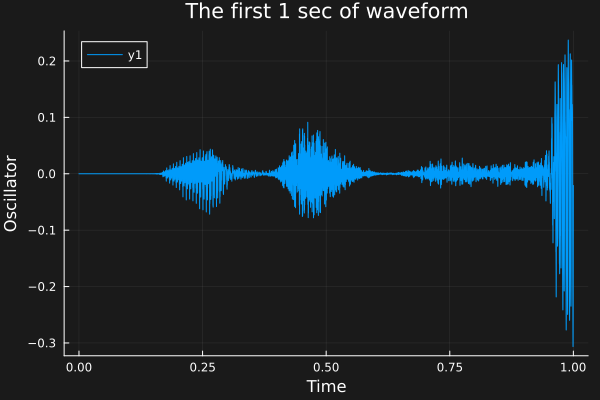

In [45]:
function toWav(stftmodel::STFTModel)
	magnitudes = stftmodel.mag
	nfft = stftmodel.nfft
	noverlap = stftmodel.noverlap
	window = stftmodel.window
	wav = istft(Float64, magnitudes; nfft, noverlap, window)
	return wav
end

wav = toWav(ex_clean_stft)
wavwrite(wav, "./aud/output/example_istft.wav"; Fs = 48000)
plotWave(wav; howmanysec = 1)


In [46]:
function pad(matrix::Matrix{T}, pad_size::Tuple{Int, Int}) where {T <: Any}
	a, b = pad_size
	@assert a >= 0 && b >= 0 "Padding sizes must be non-negative"

	N, M = size(matrix)
	padded_matrix = zeros(T, N + 2 * a, M + 2 * b)
	padded_matrix[(a+1):(a+N), (b+1):(b+M)] = matrix

	return padded_matrix
end

withenv("LINES" => 20, "COLUMNS" => 150) do
	display(ex_noisy_stft.mag)
	display("========== V V V V V V V V V After Padding V V V V V V V V V ==========")
	display(pad(ex_noisy_stft.mag, (3, 1)))
end


8001×45 Matrix{ComplexF64}:
   10.9735+0.0im        13.827+0.0im        10.4424+0.0im        …    12.0144+0.0im         6.72255+0.0im          11.1782+0.0im
  -12.2332+4.84653im   -4.4148-3.9683im    -4.96725+1.44946im        -2.83019-12.2669im    -4.12853+5.11523im    -0.432778+0.136314im
   10.2745+1.03551im  -2.21703-2.70283im   -7.95899-3.36822im        -15.2764+20.5057im     10.7823-11.9391im     -11.1072+7.21484im
  -10.6658+9.77847im   5.31117+17.5473im    17.7325-1.17428im         12.7688-7.16186im    -6.09978+1.42103im      7.26158-4.64091im
   8.64197-15.4354im   2.01971-14.0098im   -6.24137+1.61672im         -3.6427+4.01669im    -5.37561+5.60599im     -4.64472+2.28074im
  -0.21528+11.6371im  -7.43569+2.24417im   -7.03241-3.3951im     …   -3.65937-0.605348im    5.06691-6.52757im      5.42378+1.55255im
  -1.24797-4.89046im   5.83494+5.75443im   0.827434-12.4033im         10.5252-7.68653im    -11.9755+2.62698im      4.45806+4.94952im
   3.99446-8.70371im  -4.58666-9.72213im    

"========== V V V V V V V V V After Padding V V V V V V V V V =========="

8007×47 Matrix{ComplexF64}:
 0.0+0.0im       0.0+0.0im           0.0+0.0im           0.0+0.0im      …        0.0+0.0im              0.0+0.0im       0.0+0.0im
 0.0+0.0im       0.0+0.0im           0.0+0.0im           0.0+0.0im               0.0+0.0im              0.0+0.0im       0.0+0.0im
 0.0+0.0im       0.0+0.0im           0.0+0.0im           0.0+0.0im               0.0+0.0im              0.0+0.0im       0.0+0.0im
 0.0+0.0im   10.9735+0.0im        13.827+0.0im       10.4424+0.0im           6.72255+0.0im          11.1782+0.0im       0.0+0.0im
 0.0+0.0im  -12.2332+4.84653im   -4.4148-3.9683im   -4.96725+1.44946im      -4.12853+5.11523im    -0.432778+0.136314im  0.0+0.0im
 0.0+0.0im   10.2745+1.03551im  -2.21703-2.70283im  -7.95899-3.36822im  …    10.7823-11.9391im     -11.1072+7.21484im   0.0+0.0im
 0.0+0.0im  -10.6658+9.77847im   5.31117+17.5473im   17.7325-1.17428im      -6.09978+1.42103im      7.26158-4.64091im   0.0+0.0im
 0.0+0.0im   8.64197-15.4354im   2.01971-14.0098im  -6.24137+1


#### 3.2.1 > Audio Denoiser v2.0
In this edition... !!!



Loading files...
Training started...
The size of this STFT model is: (8001, 45)
Time range of this model: 0.0:0.08333333333333333:3.6666666666666665
Frequency range of this model: 0.0:3.0:24000.0

The size of this STFT model is: (8001, 45)
Time range of this model: 0.0:0.08333333333333333:3.6666666666666665
Frequency range of this model: 0.0:3.0:24000.0

Denoising audio...
The size of this STFT model is: (8001, 45)
Time range of this model: 0.0:0.08333333333333333:3.6666666666666665
Frequency range of this model: 0.0:3.0:24000.0

Denoised audio saved to ./aud/output/denoised_audio_v2.0.wav
An image of training loss saved to ./log/loss_plot_v2.0.png


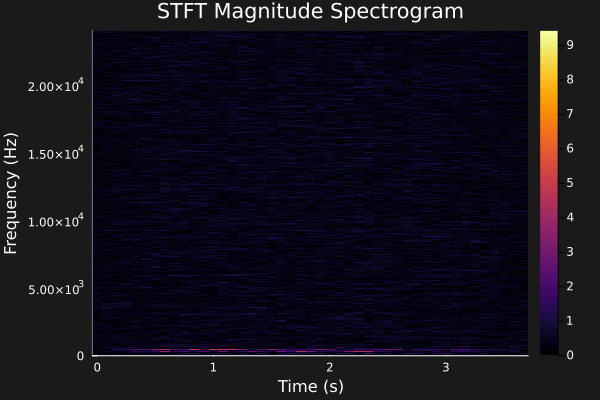

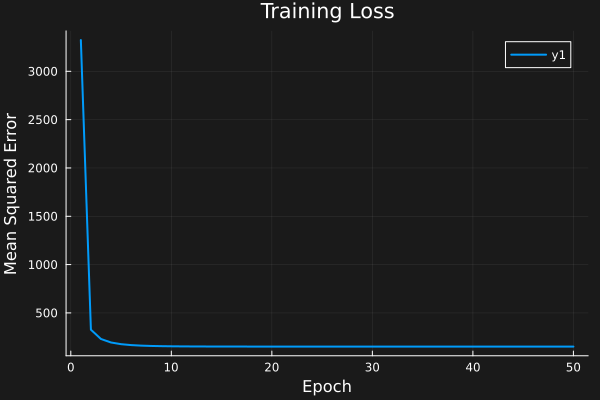

Adaline(-0.04281243622239699, [-0.0003669064084611696, -0.0037226022706843206, -0.003815575826952755, -0.0006980686931941913, 0.0026652804800331785, 0.002481869075080762, 0.0016372753990343944, -0.00017107349571842916, 0.0019834490979339973, 0.003551395884062325  …  -0.0015715113247345106, -0.0023085260017235688, -0.003289332387032815, -0.00396562246414728, -0.002971514634088299, -0.003443710251579068, -0.002020899354585672, 0.0015687838600825553, 0.002443319121028124, 0.0020719395994061515], 1.0e-7, 50, [1602.1510181035767, 166.6728107739958, 119.50237235889357, 100.2980048169272, 90.64003204196088, 85.23331052657743, 82.00099358899574, 79.98245823482792, 78.68175873955468, 77.82288007108073  …  75.7295712753276, 75.72856039365654, 75.72768574913304, 75.72692890870098, 75.72627395714801, 75.72570714541203, 75.72521659051279, 75.72479201874995, 75.72442454540008, 75.72410648531834])

Adaline(-0.008151827145715256, [-0.00030821679384053757, 0.002711922593898311, 0.004797660955443576, 0.004305436137695948, 0.003714340506514608, 0.0027852804410607116, 0.002603043830791545, 0.002197148632166995, 0.0006926565062203734, -0.0010198537292224147  …  0.0005972890416412589, 0.001676735943373442, 0.0006123444853032866, -0.002595426423904284, -0.004188394741855023, -0.001783782335762749, 0.0024138732992712046, 0.0037745028623241616, 0.0023275593086698417, 0.00044953611118735885], 1.0e-7, 50, [1721.2881693941706, 159.6462240969959, 110.69983972024356, 93.72611863180128, 85.93616931973875, 81.85352461854859, 79.5405510222822, 78.1622655445414, 77.31193218808383, 76.77406004296301  …  75.7410783216933, 75.74105330909917, 75.74103201660655, 75.74101382794947, 75.740998246907, 75.74098486932134, 75.7409733626617, 75.74096345085769, 75.74095490296015, 75.74094752450655])

-0.006981550539463834

0.04053825807783911

In [47]:

function activation(adaline::Adaline, x::Float64)
	return x
end

function predict(adaline::Adaline, x::Vector{Float64})
	return activation(adaline, dot(x, adaline.weights) + adaline.bias)
end

function denoise_frame(adaline::Adaline, noisy_frame::Vector{Float64}, context_size::Int)
	# Simplified - use entire window
	predict(adaline, noisy_frame)
end

function train!(adaline::Adaline, X::Matrix{Float64}, y::Matrix{Float64})
	loss_history = Float64[]

	n_samples = size(X, 1)
	for ep in 1:adaline.epochs
		total_loss = 0.0
		error = 0
		for i in 1:n_samples
			xi = X[i, :]
			target = y[i]
			prediction = predict(adaline, xi)
			error = target - prediction
			total_loss += error^2
			adaline.weights .+= adaline.learning_rate * error * xi * 2
			adaline.bias += adaline.learning_rate * error * 2
		end
		push!(loss_history, total_loss / n_samples)
	end
	adaline.loss_history = loss_history
	return loss_history
end

function create_training_data(noisy_stft::STFTModel, clean_stft::STFTModel, window_size::Tuple{Int, Int})
	@assert size(clean_stft.mag) == size(noisy_stft.mag)

	# Prepare  padding
	pad_size = window_size .÷ 2
	padded_noisy = pad(noisy_stft.mag, pad_size)

	# Create training matrix
	n_samples = height(noisy_stft) * width(noisy_stft)
	window_height, window_width = window_size
	X = zeros(Float64, 2, n_samples, window_height * window_width)
	for i in 1:height(noisy_stft)
		for j in 1:width(noisy_stft)
			x = padded_noisy[i:(i+window_height-1), j:(j+window_width-1)]
			X[1, (i-1)*width(noisy_stft)+j, :] = real(x)
			X[2, (i-1)*width(noisy_stft)+j, :] = imag(x)
		end
	end

	return X, clean_stft.mag
end

function train_an_adaline_for_denoising(noisy_audio::String, clean_audio::String; window_size::Tuple{Int, Int} = (5, 5), learning_rate = 0.0000001, epochs = 50)
	# Read and normalize audio file
	clean_wav, sr = preprocess_audio(clean_audio)
	noisy_wav, _ = preprocess_audio(noisy_audio)

	# Transform waveform audio to Short-Time Fourier model
	noisy_stft = toSTFT(noisy_wav)
	clean_stft = toSTFT(clean_wav)
	# noisy_stft = toSTFT(noisy_wav)
	# clean_stft = toSTFT(clean_wav)

	X, y = create_training_data(noisy_stft, clean_stft, window_size)
	adaline_rl = Adaline(window_size[1]*window_size[2]; learning_rate = learning_rate, epochs = epochs)
	adaline_im = Adaline(window_size[1]*window_size[2]; learning_rate = learning_rate, epochs = epochs)
	loss_history_rl = train!(adaline_rl, X[1, :, :], real(y))
	loss_history_im = train!(adaline_im, X[2, :, :], imag(y))
	return adaline_rl, adaline_im, loss_history_rl, loss_history_im
end

function denoise_audio(noisy_audio::String, adaline_rl::Adaline, adaline_im::Adaline, output_audio::String, window_size::Tuple{Int, Int} = (5, 5), context_size = 2)
	noisy_wav, fs = preprocess_audio(noisy_audio)

	noisy_stft = toSTFT(noisy_wav)
	# noisy_stft = toSTFT(noisy_wav)

	# Prepare  padding
	pad_size = window_size .÷ 2
	padded_noisy = pad(noisy_stft.mag, pad_size)



	# Create input matrix
	N = width(noisy_stft) * height(noisy_stft)
	# X = zeros(Float64, N, window_size)
	# for i in 1:N
	# 	X[i, :] = padded_noisy[i:(i+window_size-1)]
	# end
	window_height, window_width = window_size
	X = zeros(Float64, 2, N, window_height * window_width)
	for i in 1:height(noisy_stft)
		for j in 1:width(noisy_stft)
			x = padded_noisy[i:(i+window_height-1), j:(j+window_width-1)]
			X[1, (i-1)*width(noisy_stft)+j, :] = real(x)
			X[2, (i-1)*width(noisy_stft)+j, :] = imag(x)
		end
	end


	N, M = height(noisy_stft), width(noisy_stft)
	denoised_rl = zeros(ComplexF64, N, M)
	for i in 1:N
		for j in 1:M
			window = X[1, (i-1)*width(noisy_stft)+j, :]
			denoised_rl[i, j] = denoise_frame(adaline_rl, window, context_size)
		end
	end
	denoised_im = zeros(ComplexF64, N, M)
	for i in 1:N
		for j in 1:M
			window = X[2, (i-1)*width(noisy_stft)+j, :]
			denoised_im[i, j] = denoise_frame(adaline_im, window, context_size)
		end
	end

	denoised_stft = noisy_stft
	denoised_stft.mag = denoised_rl+(denoised_im)im
	denoised_wav = toWav(denoised_stft)

	#????????????????????????
	#!!!!!!!!!!!!!!!!!!!!!!!
	#**********************
	denoised_stft.mag*=2
	display(heatmapSTFT(denoised_stft))

	# Normalize
	denoised_wav = denoised_wav / maximum(abs.(denoised_wav))

	# Save the output
	wavwrite(denoised_wav, output_audio; Fs = fs)
	return denoised_wav, fs
end



function denoise_audio(window_size::Union{Int, Tuple{Int, Int}} = 5; ver::String = "")
	# Add one to window_size if it's even
	window_size = window_size .÷ 2 .* 2 .+ 1

	printstyled("Loading files...\n"; color = :yellow)
	noisy_audio = "./aud/learn/noisy/noisy_audio.wav" #> to train
	clean_audio = "./aud/learn/clean/clean_audio.wav" #> to train
	input_audio = "./aud/input/noisy_test.wav" #> to denoise
	output_audio = "./aud/output/denoised_audio_v$ver.wav" #> to save

	# * input_audio = "./aud/learn/noisy/noisy_audio.wav"
	# * output_audio = "./aud/output/denoised_audio.wav"

	# Verify files exist
	for f in [clean_audio, noisy_audio, input_audio]
		isfile(f) || error("File not found: $f")
	end

	# Define and train an adaline for denoising
	printstyled("Training started...\n"; color = :magenta)
	adaline_rl, adaline_im, lh_rl, lh_im = train_an_adaline_for_denoising(noisy_audio, clean_audio; window_size)

	# Denoising through the trained adaline
	printstyled("Denoising audio...\n"; color = :magenta)
	denoise_audio(input_audio, adaline_rl, adaline_im, output_audio, window_size)
	printstyled("Denoised audio saved to $output_audio\n"; color = :light_green)

	# Optional: Plot training loss
	display(plot(lh_rl+lh_im, title = "Training Loss", xlabel = "Epoch", ylabel = "Mean Squared Error", lw = 2, background = "gray10"))
	lossimglog = "./log/loss_plot_v$ver.png"
	savefig(lossimglog)
	printstyled("An image of training loss saved to $lossimglog\n"; color = :green)
	display(adaline_rl)
	display(adaline_im)
	display(sum(adaline_rl.weights))
	display(sum(adaline_im.weights))
end


# noisy_audio = "./aud/learn/noisy/noisy_audio.wav" #> to train
# clean_audio = "./aud/learn/clean/clean_audio.wav" #> to train
# a, b = train_an_adaline_for_denoising(noisy_audio, clean_audio)
# println(a)
# println(b)

denoise_audio((15, 15); ver = "2.0")



In [48]:

# pathtofrq = "./aud/output/denoised_audio_v2.0.wav"
# ex_frq, _ = preprocess_audio(pathtofrq)
# plotWave(ex_frq,howmanysec=1)

#=

pathtofrq = "./aud/learn/clean/clean_audio.wav"
ex_frq, _ = preprocess_audio(pathtofrq)
k6 = toSTFT(ex_frq,16000,15300)


in_db=true
display(heatmapSTFT(k6; in_db))
withenv("LINES" => 100, "COLUMNS" => 1500) do
	display(k6.mag[140:150,10:20])
end

# for i in 1:size(k6.mag, 1)
# 	if i == 2001
# 		continue
# 	end
# 	for j in 1:size(k6.mag, 2)
# 		k6.mag[i,j]=0
# 	end
# end

# k6.mag -= imag(k6.mag)im
k6.mag = complex(real(k6.mag)+imag(k6.mag))

# k6.mag[100:250,:] = muladd.(k6.mag[100:250,:],3,0)

display(heatmapSTFT(k6; in_db))
withenv("LINES" => 100, "COLUMNS" => 1500) do
	display(k6.mag[140:150,10:20])
end

wav = toWav(k6)
display(plotWave(wav,howmanysec=1))
wavwrite(wav, "./aud/output/hz6kout.wav"; Fs = 48000)

=#